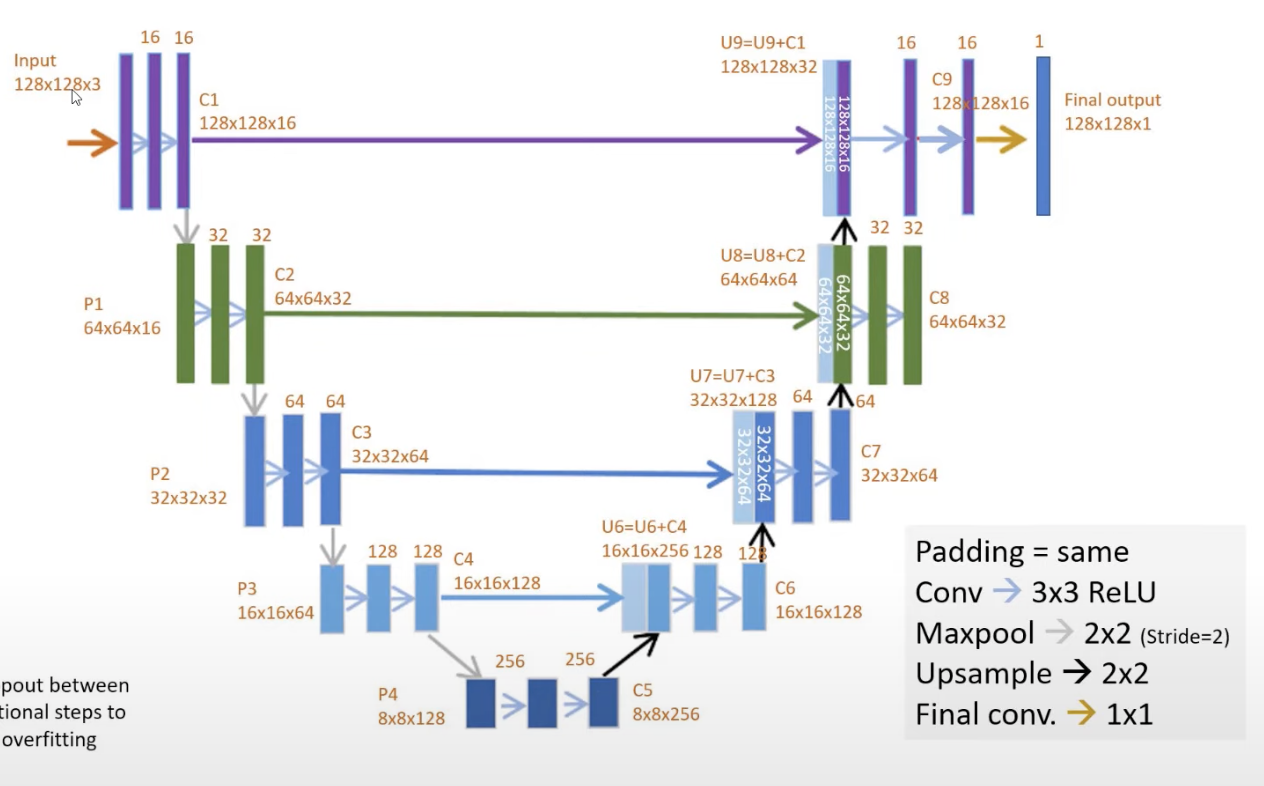

In [166]:
import tensorflow as tf
import os
import sys
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [167]:
# Constants
IMG_WIDTH = 400
IMG_HEIGHT = 400
IMG_CHANNELS = 3

In [218]:
# Model
#dropouts were added to avoid overfitting

#Encoder Path
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

#transform input which can be integer value into floating point values
transform = tf.keras.layers.Lambda(lambda x : x / 255.0)(inputs)

#first convolution
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(transform)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c1)

#first pooling
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

#second convolution
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c2)

#second pooling
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

#third convolution
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c3)

#third pooling
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

#fourth convolution
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c4)

#fourth pooling
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

#fifth convolution
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(c5)


#Decoder Path
#at each step we concatenate the results from the encoder path with the results from the deocder path => improves image segmentation


#first upsampling
u1 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding="same")(c5)
u1 = tf.keras.layers.concatenate([u1, c4])
u1 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u1)
u1 = tf.keras.layers.Dropout(0.1)(u1)
u1 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u1)

#second upsampling
u2 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding="same")(u1)
u2 = tf.keras.layers.concatenate([u2, c3])
u2 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u2)
u2 = tf.keras.layers.Dropout(0.1)(u2)
u2 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u2)

#third upsampling
u3 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding="same")(u2)
u3 = tf.keras.layers.concatenate([u3, c2])
u3 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u3)
u3 = tf.keras.layers.Dropout(0.1)(u3)
u3 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u3)

#fourth upsampling
u4 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding="same")(u3)
u4 = tf.keras.layers.concatenate([u4, c1])
u4 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u4)
u4 = tf.keras.layers.Dropout(0.1)(u4)
u4 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",padding="same")(u4)



out = tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid")(u4)


# ***************************** test ***************************
#reshape to get matching dimensions
out = tf.keras.layers.Reshape((IMG_WIDTH * IMG_HEIGHT, 1))(out)

# ***************************** test ***************************
model = tf.keras.Model(inputs = [inputs], outputs=[out])


#"binary_crossentropy"
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"],sample_weight_mode="temporal")
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
lambda_35 (Lambda)              (None, 400, 400, 3)  0           input_39[0][0]                   
__________________________________________________________________________________________________
conv2d_630 (Conv2D)             (None, 400, 400, 16) 448         lambda_35[0][0]                  
__________________________________________________________________________________________________
dropout_301 (Dropout)           (None, 400, 400, 16) 0           conv2d_630[0][0]                 
__________________________________________________________________________________________________
conv2d_631

In [228]:
# Define our data (inputs and labels)
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

# Assign a label to a patch v
def value_to_class(v):
    foreground_threshold = 0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
    df = np.sum(v)
    if df > foreground_threshold:  # road
        return [0, 1]
    else:  # bgrd
        return [1, 0]
    
TRAIN_PATH = "/Users/abiola/Documents/EPFL/ML_Project2_Road_Segmentation/Ressources/training/"
TEST_PATH = "/Users/abiola/Documents/EPFL/ML_Project2_Road_Segmentation/Ressources/test_set_images/"

n = 50

image_dir = TRAIN_PATH + "images/"
files = os.listdir(image_dir)

imgs = [load_image(image_dir + files[i]) for i in range(n)]
imgs = np.asarray(imgs)

gt_dir = TRAIN_PATH + "groundtruth/"
files = os.listdir(gt_dir)

gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
gt_imgs = np.asarray(gt_imgs)

mask = np.where(gt_imgs > 0.5)
labels = np.zeros(gt_imgs.shape)
labels[mask] = 1


test_image_dir = TEST_PATH
files = os.listdir(test_image_dir)

nb_test_imgs = len(files)

test_imgs = [load_image(test_image_dir + files[i]) for i in range(nb_test_imgs)]
test_imgs = np.asarray(test_imgs)

X_train = imgs
X_test = test_imgs
Y_train = labels.reshape(n,IMG_WIDTH,IMG_WIDTH,1)

print("Y_train: ",Y_train.shape)
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)




Y_train:  (50, 400, 400, 1)
X_train:  (50, 400, 400, 3)
X_test:  (50, 608, 608, 3)


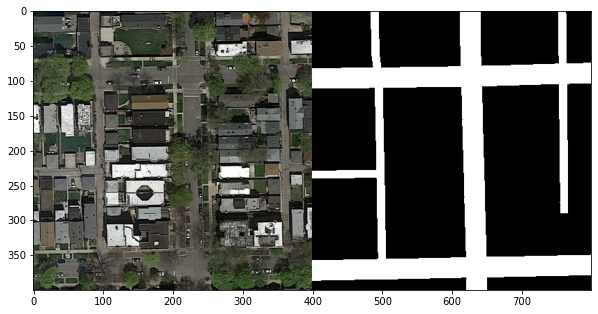

In [229]:
# Show some images to see if everything is fine

PIXEL_DEPTH = 255

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)
    return rimg

def concatenate_images(img, gt_img):
    n_channels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if n_channels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

gt = Y_train.reshape((-1,400,400))
cimg = concatenate_images(X_train[10],gt[10])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [233]:
#Callbacks for fit methods

#1. checkpoints to save timestamps of model during training
checkpoints = tf.keras.callbacks.ModelCheckpoint("road_semgentation_unet.h5", verbose=1, save_best_only = True)

#2. eraly stopping callback to avoid useless epochs
early_stopping = tf.keras.callbacks.EarlyStopping(patience=6, monitor="val_loss")

#3. tensorboard to visulaize various statistics during training
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

callbacks = [checkpoints,early_stopping,tensorboard]


In [235]:
# Our data is skewed: we have way more background pixels than road pixels, therefore it is important to give more weight to the road samples

nb_training_samples = len(Y_train)
sample_weight = np.zeros((nb_training_samples,IMG_WIDTH*IMG_HEIGHT))
print(sample_weight.shape)
sample_weight[:,0] += 1
sample_weight[:,1] += 8



(50, 160000)


In [ ]:
results = model.fit(X_train,Y_train.reshape((nb_training_samples,IMG_WIDTH*IMG_HEIGHT,1)),validation_split = 0.15, batch_size=10 , epochs = 30, callbacks = callbacks,sample_weight=sample_weight)


Train on 42 samples, validate on 8 samples
Epoch 1/30
40/42 [===========================>..] - ETA: 1s - loss: 0.1904 - acc: 0.8032 
Epoch 00001: val_loss improved from inf to 1.23424, saving model to road_semgentation_unet.h5
42/42 [==============================] - 39s 932ms/step - loss: 0.1827 - acc: 0.8000 - val_loss: 1.2342 - val_acc: 0.7789
Epoch 2/30
40/42 [===========================>..] - ETA: 1s - loss: 0.2011 - acc: 0.7978 
Epoch 00002: val_loss improved from 1.23424 to 1.20356, saving model to road_semgentation_unet.h5
42/42 [==============================] - 39s 926ms/step - loss: 0.1937 - acc: 0.8000 - val_loss: 1.2036 - val_acc: 0.7789
Epoch 3/30
40/42 [===========================>..] - ETA: 1s - loss: 0.2168 - acc: 0.7958 
Epoch 00003: val_loss did not improve from 1.20356
42/42 [==============================] - 38s 912ms/step - loss: 0.2081 - acc: 0.7989 - val_loss: 1.2785 - val_acc: 0.7789
Epoch 4/30
40/42 [===========================>..] - ETA: 1s - loss: 0.2112 - a

1/1 [==============================] - 0s 349ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<ipython-input-189-282c5f3b3843>:7: RuntimeWarning: invalid value encountered in true_divide
  rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)


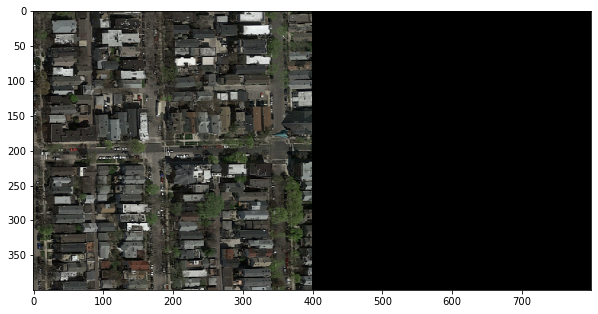

In [227]:
#Testing our model

#Test on a random image from the test set
idx = random.randint(0, len(X_test)-1)
elem = X_test[idx]
elem = cv2.resize(elem, (400,400), interpolation = 0)
elem = elem.reshape((1,400,400,3))
pred = model.predict(X_train[0].reshape((1,400,400,3)), verbose = 1)

pred = ((pred > 0.5).astype(np.uint8)).reshape((400,400))
print(pred)

cimg = concatenate_images(elem.reshape((400,400,3)),pred.reshape((400,400)))
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [147]:
!tensorboard --logdir=logs/ --host localhost --port 9999

/Users/abiola/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/abiola/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/abiola/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/abiola/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework